In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from datetime import datetime
import gc

vehicles_full = pd.read_csv("./Data2_raw.csv")

# Preprocessing for Data2.csv

## First look:

In [2]:
vehicles_full

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,...,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:31-0600
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,...,NaN,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:29-0600
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,...,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,...,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:11-0600


## Null values:

Seems like there are a lot of null values, take a closer look:

In [3]:
vehicles_full.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

Good, id and price have no nulls. We can leave the rest in for now.

## Confirm primary key constraint

In [4]:
print(f"vehicles_full has {vehicles_full.shape[0]} number of tuples")
print(f"id variable has {vehicles_full.id.nunique()} number of unique values")
print(f"Do the numbers match: {vehicles_full.shape[0] == vehicles_full.id.nunique()}")

vehicles_full has 426880 number of tuples
id variable has 426880 number of unique values
Do the numbers match: True


We're good. Note that all the id values might exceed MySQL INT range depending on system, so we'll need to use LONG.

## Columns to discard completely:

In [5]:
to_discard = set()

### County

Kaggle page mentioned `county` is useless:

In [6]:
vehicles_full.county.isnull().all()

True

Yep, useless.

In [7]:
to_discard.add("county")

### Url's

We won't need `url`, `region_url`, or `image_url`, so we don't have to include them.

In [8]:
to_discard.add("url")
to_discard.add("region_url")
to_discard.add("image_url")

### Description

In [9]:
vehicles_full.description.str.len().max()

28832.0

`description` has some very, very long strings and isn't useful for our purposes. Additionally, commas in its entries might mess up MySQL csv parser, so throw it out too.

In [10]:
to_discard.add("description")

### Discard!

In [11]:
to_discard

{'county', 'description', 'image_url', 'region_url', 'url'}

In [12]:
vehicles_full = vehicles_full.drop(to_discard, axis=1)

## Basic cleaning

### Deleting price outliers

<Axes: xlabel='price', ylabel='Density'>

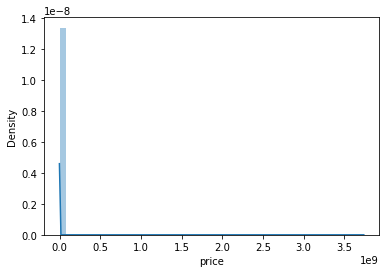

In [13]:
sns.distplot(vehicles_full.price)

There is/are some crazy outliers! Let's see what they are:

In [14]:
vehicles_full.nlargest(3, "price")

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,transmission,VIN,drive,size,type,paint_color,state,lat,long,posting_date
318592,7308056031,eugene,3736928711,2007.0,toyota,tundra,excellent,8 cylinders,gas,164000.0,...,automatic,NaN,4wd,full-size,pickup,silver,or,44.066092,-124.037561,2021-04-16T18:16:12-0700
356716,7302445002,knoxville,3736928711,1999.0,toyota,4runner,fair,6 cylinders,gas,211000.0,...,automatic,NaN,4wd,mid-size,NaN,green,tn,36.081000,-83.567300,2021-04-05T23:15:48-0400
91576,7309730903,delaware,3024942282,2000.0,mercedes-benz,benz e320,NaN,NaN,gas,100000.0,...,automatic,NaN,NaN,NaN,NaN,NaN,de,39.703511,-75.746681,2021-04-20T08:46:47-0400


There is no way a Toyota Tundra costs 3 billion... there has to be some error. Let's check the manufacturers of all cars greater than 300k:

In [15]:
vehicles_full[vehicles_full.price > 300000].manufacturer.value_counts()

chevrolet        28
ford              7
jeep              4
mercedes-benz     3
ferrari           3
gmc               3
porsche           3
dodge             2
chrysler          2
toyota            2
ram               1
buick             1
volvo             1
lincoln           1
nissan            1
bmw               1
saturn            1
Name: manufacturer, dtype: int64

With the exception of ferrari and porsche, there is no way these brands have used cars > 300k...  

For now, let's just drop everything greater than 300k and risk losing a few non-error luxury cars (seems like there are only 6 of those so we're good).

In [16]:
vehicles_full = vehicles_full[vehicles_full.price < 300000]

Now check the price distribution again:

<Axes: xlabel='price', ylabel='Density'>

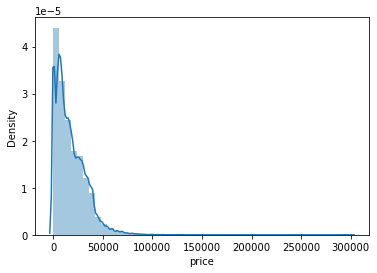

In [17]:
sns.distplot(vehicles_full.price)

Much more reasonable!

### Deleting free cars

That said, there seems to be some cars with price 0:

In [18]:
vehicles_full[vehicles_full.price <= 0].shape[0]

32895

That's a good amount... I'm guessing the price was missing or otherwise not found, since I doubt there are almost 33k free cars floating around (can I have one?). For now, let's just drop them:

In [19]:
vehicles_full = vehicles_full[vehicles_full.price > 0]

### Odometer

The odometer value tends to be one of the most important determiners in used car prices, let's take a look:

<Axes: xlabel='odometer', ylabel='Density'>

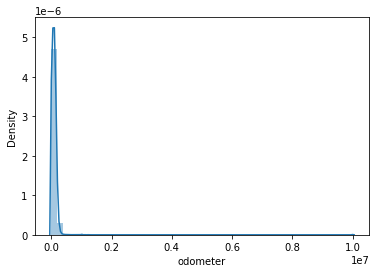

In [20]:
sns.distplot(vehicles_full.odometer)

Once again, some crazy values...

In [21]:
vehicles_full.nlargest(3, "odometer")

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,transmission,VIN,drive,size,type,paint_color,state,lat,long,posting_date
9218,7303842844,flagstaff / sedona,4000,1975.0,ford,f250,NaN,NaN,gas,10000000.0,...,manual,NaN,NaN,NaN,NaN,NaN,az,35.213621,-111.618176,2021-04-08T13:29:36-0700
23100,7305498365,bakersfield,15000,1957.0,chevrolet,nomad,NaN,NaN,gas,10000000.0,...,automatic,NaN,NaN,NaN,NaN,NaN,ca,33.887900,-118.351000,2021-04-11T22:35:15-0700
28738,7307413811,gold country,20000,1951.0,chevrolet,coe,good,8 cylinders,gas,10000000.0,...,automatic,NaN,rwd,full-size,truck,custom,ca,37.956759,-120.311279,2021-04-15T14:11:51-0700


Most older odometers cap at 999,999, so I doubt these values are correct. In any case, a car with more than a million miles on it are probably not going for 20k...

For now, let's just drop everything with more than a million miles, since anything even remotely close to that number would be very, very rare indeed.

<Axes: xlabel='odometer', ylabel='Density'>

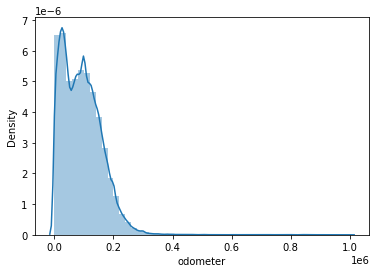

In [22]:
vehicles_full = vehicles_full[vehicles_full.odometer < 999999]
sns.distplot(vehicles_full.odometer)

### Split out date

In [23]:
vehicles_full.posting_date

27        2021-05-04T12:31:18-0500
28        2021-05-04T12:31:08-0500
29        2021-05-04T12:31:25-0500
30        2021-05-04T10:41:31-0500
31        2021-05-03T14:02:03-0500
                    ...           
426875    2021-04-04T03:21:31-0600
426876    2021-04-04T03:21:29-0600
426877    2021-04-04T03:21:17-0600
426878    2021-04-04T03:21:11-0600
426879    2021-04-04T03:21:07-0600
Name: posting_date, Length: 390863, dtype: object

We don't care about time, so just keep date: but is it yyyy-mm-dd or yyyy-dd-mm?

In [24]:
vehicles_full.posting_date.str[5:7].astype(int).max()

5

In [25]:
vehicles_full.posting_date.str[8:10].astype(int).max()

30

Yep, definitely yyyy-mm-dd. Now let's split it out:

In [26]:
vehicles_full["posting_year"] = vehicles_full.posting_date.str[0:4].astype(int)
vehicles_full["posting_month"] = vehicles_full.posting_date.str[5:7].astype(int)
vehicles_full["posting_day"] = vehicles_full.posting_date.str[8:10].astype(int)
vehicles_full = vehicles_full.drop("posting_date", axis=1)

### Everything else

Everything else seem fairly standard, just to look through a few to get a better sense of the data:

In [27]:
vehicles_full["type"].value_counts()

sedan          79697
SUV            69966
pickup         41041
truck          30520
other          19791
coupe          18036
hatchback      15874
wagon          10009
van             7952
convertible     7378
mini-van        4520
offroad          586
bus              493
Name: type, dtype: int64

I'm surprised sedans still rank above SUVs, but that's cool!

In [28]:
vehicles_full["transmission"].value_counts()

automatic    304398
other         61415
manual        23531
Name: transmission, dtype: int64

I wonder what "other" is... let's check:

In [29]:
vehicles_full[vehicles_full.transmission == "other"].model.value_counts()

Scion iM Hatchback 4D     640
1500 crew cab big horn    589
silverado 1500 regular    509
camaro ss coupe 2d        495
silverado 1500 double     482
                         ... 
r350                        1
328xi                       1
versa sedan                 1
328i                        1
ATI                         1
Name: model, Length: 3211, dtype: int64

Hmmm... looks like "other" might just mean "missing", since for at least a few of these cars I'm fairly positive there are no other options than x-speed automatic or x-speed manual offered... It is what it is, when modelling might need to pay attention to this though, we'll see.

### Camaros cuz I'm curious

In [30]:
camaros = vehicles_full[vehicles_full.model.str.contains("camaro", na=False)]

What's the price like?

In [31]:
camaros.price.describe()

count      2377.000000
mean      25457.644931
std       14933.736230
min           1.000000
25%       14950.000000
50%       24900.000000
75%       36990.000000
max      135000.000000
Name: price, dtype: float64

Average seems a little low.. what if we split by 5th gen and 6th gen?

In [32]:
camaros[camaros.year <= 2015].price.mean()

19676.566870332656

In [33]:
camaros[camaros.year > 2015].price.mean()

34877.476769911504

Makes much more sense -> this a good example of why more discreet methods (trees?) actually might work better for this problem.

For even more granualarity, split by cylinders too:

In [34]:
fifth_gen_mask = camaros.year <= 2015
V6_mask = camaros.cylinders == "6 cylinders"

print(f"Camaro 5th gen V6 average price {camaros[fifth_gen_mask&V6_mask].price.mean()}")
print(f"Camaro 5th gen V8 average price {camaros[fifth_gen_mask&(~V6_mask)].price.mean()}")
print(f"Camaro 6th gen V6 average price {camaros[(~fifth_gen_mask)&V6_mask].price.mean()}")
print(f"Camaro 6th gen V8 average price {camaros[(~fifth_gen_mask)&(~V6_mask)].price.mean()}")

Camaro 5th gen V6 average price 13753.656084656084
Camaro 5th gen V8 average price 21721.188127853882
Camaro 6th gen V6 average price 24553.093959731545
Camaro 6th gen V8 average price 36915.003973509934


Save the manuals?

In [35]:
camaros.transmission.value_counts()

automatic    1144
other         817
manual        411
Name: transmission, dtype: int64

Nope... fine.

## Rename some columns for clarity

Let's use the naming convention where all variables are lower case with underscores as word deliminators, and all relations are upper camal case.

In [36]:
vehicles_full.rename(columns= {
    "id":"posting_id",
    "region":"posting_region",
    "year":"model_year",
    "model":"description",
    "fuel":"fuel_type",
    "VIN":"vin",
    "drive": "drivetrain",
    "size":"vehicle_size",
    "type":"vehicle_type",
    "paint_color":"exterior_color",
    "state":"posting_state",
    "lat":"latitude",
    "long":"longitude"
}, inplace=True)
vehicles_full.columns

Index(['posting_id', 'posting_region', 'price', 'model_year', 'manufacturer',
       'description', 'condition', 'cylinders', 'fuel_type', 'odometer',
       'title_status', 'transmission', 'vin', 'drivetrain', 'vehicle_size',
       'vehicle_type', 'exterior_color', 'posting_state', 'latitude',
       'longitude', 'posting_year', 'posting_month', 'posting_day'],
      dtype='object')

## Get some info about max column string lengths for varchar

In [37]:
for column in vehicles_full.columns:
    print(f"{column} has dtype {vehicles_full[column].dtype}")
    if vehicles_full[column].dtype == "O":
        print(f"{column} has max char length {vehicles_full[column].str.len().max()}")
    print("")

posting_id has dtype int64

posting_region has dtype object
posting_region has max char length 26

price has dtype int64

model_year has dtype float64

manufacturer has dtype object
manufacturer has max char length 15.0

description has dtype object
description has max char length 192.0

condition has dtype object
condition has max char length 9.0

cylinders has dtype object
cylinders has max char length 12.0

fuel_type has dtype object
fuel_type has max char length 8.0

odometer has dtype float64

title_status has dtype object
title_status has max char length 10.0

transmission has dtype object
transmission has max char length 9.0

vin has dtype object
vin has max char length 20.0

drivetrain has dtype object
drivetrain has max char length 3.0

vehicle_size has dtype object
vehicle_size has max char length 11.0

vehicle_type has dtype object
vehicle_type has max char length 11.0

exterior_color has dtype object
exterior_color has max char length 6.0

posting_state has dtype object
pos

## Export processed csv

In [38]:
vehicles_full.to_csv("./Data2_preprocessed.csv", na_rep="NULL", index=False)